# Model Predictions
## Predicting Rates of Chronic Absenteeism

In [118]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier 
import datetime
from pandas_profiling import ProfileReport

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn import tree, metrics
from io import StringIO  
from IPython.display import Image  
#import pydotplus

import matplotlib.style as style
style.use('fivethirtyeight')

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [48]:
#load data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed'
os.chdir(path) 

df_classifier = pd.read_csv('more_variables_attendance_2013_18_classifier.csv', dtype={'District_Number': object})

df_18_19 = pd.read_csv('more_variables_attendance_2018_19.csv', dtype={'District_Number': object})

In [49]:
#check to ensure District Number is correctly an object, not int
df_classifier.dtypes

Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Chronically_Absent_Next_Year                  object
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [50]:
df_18_19.dtypes

Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
Chronically_Absent_Next_Year                 float64
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [55]:
#remove target variable from classification data, so it does not get turned into a dummy variable
df_classifier_dummies = pd.get_dummies(df_classifier.drop(columns=['Chronically_Absent_Next_Year', 'Year']))

#save target variable for classification
target_classifier = df_classifier['Chronically_Absent_Next_Year']

print(df_classifier_dummies.shape)

(448835, 68)


In [56]:
#define variables for classifier
X_c = df_classifier_dummies
y_c = target_classifier

In [57]:
#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X_c):
    X_train, X_test = X_c.iloc[train_index, :], X_c.iloc[test_index,:]
    y_train, y_test = y_c.iloc[train_index], y_c.iloc[test_index]

In [58]:
#load model

path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/models'
os.chdir(path)
filename = 'rf_classifier_improved_minus_year.sav'

# load the model from disk
#accuracy matches before
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7876612525900675


### Refit Model on All Available Data

In [59]:
loaded_model.fit(X_c, y_c)

RandomForestClassifier()

### Calculate Expected Vacacny Rate for 2019-2020 From The Model 

In [60]:
#define functions to get NaNs as % 
def NaNs_as_percent(dataframe):
    '''show % NaNs for each column'''
    print(dataframe.isna().sum()/len(dataframe)*100)

In [61]:
#check NaNs of 2018-19 data
NaNs_as_percent(df_18_19)

Grade                                          0.000000
Year                                           0.000000
Demographic Variable                           0.000000
% Attendance                                   0.000000
% Chronically Absent                           0.000000
Next Year % Chronically Absent               100.000000
Chronically_Absent_Next_Year                 100.000000
District_Number                                0.000000
% Attendance - diff from 5 yr avg              2.441424
% Attendance - diff from 2 yr avg              4.662672
% Chronically Absent - diff from 5 yr avg      2.441424
% Chronically Absent - diff from 2 yr avg      4.662672
dtype: float64


In [62]:
#drop NaN rows, for only the rows where target classification variable is NOT NaN
df_18_19.dropna(subset=['% Attendance - diff from 5 yr avg', '% Attendance - diff from 2 yr avg', '% Chronically Absent - diff from 5 yr avg', '% Chronically Absent - diff from 2 yr avg'], inplace=True)

In [63]:
#drop column that was used as regression target variable
df_18_19.drop(columns=['Next Year % Chronically Absent'], inplace=True)

In [64]:
#check NaNs were dealt with correctly
NaNs_as_percent(df_18_19)

Grade                                          0.0
Year                                           0.0
Demographic Variable                           0.0
% Attendance                                   0.0
% Chronically Absent                           0.0
Chronically_Absent_Next_Year                 100.0
District_Number                                0.0
% Attendance - diff from 5 yr avg              0.0
% Attendance - diff from 2 yr avg              0.0
% Chronically Absent - diff from 5 yr avg      0.0
% Chronically Absent - diff from 2 yr avg      0.0
dtype: float64


In [73]:

#create X and y variables for years 2019-2020
X_18_19 = df_18_19.drop(['Chronically_Absent_Next_Year', 'Year'], axis=1)
y_18_19 = df_18_19['Chronically_Absent_Next_Year']

In [74]:
X_18_19.dtypes

Grade                                         object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [75]:
#turn categorical variables into binary for predicting with get dummies
X_18_19_dummy = pd.get_dummies(X_18_19)

In [76]:
#predict next year's vacancy rate (2019-20) for school year 2018-19
pred_18_19 = loaded_model.predict(X_18_19_dummy)

In [77]:
pred_18_19

array(['Medium', 'High', 'Medium', ..., 'High', 'High', 'High'],
      dtype=object)

In [78]:
X_18_19['Chronically_Absent_Next_Year'] = pred_18_19
X_18_19

,Grade,Demographic Variable,% Attendance,% Chronically Absent,District_Number,% Attendance - diff from 5 yr avg,% Attendance - diff from 2 yr avg,% Chronically Absent - diff from 5 yr avg,% Chronically Absent - diff from 2 yr avg,Chronically_Absent_Next_Year
0,All Grades,All Students,92.6,24.2,01,-0.460000,-1.05,-0.120000,2.25,Medium
1,PK in K-12 Schools,All Students,88.4,50.0,01,-0.375000,-4.20,2.325000,27.80,High
2,0K,All Students,91.9,28.6,01,0.180000,-0.65,-1.960000,-1.85,Medium
3,1,All Students,90.7,28.6,01,-2.460000,-3.25,2.960000,12.15,Medium
4,2,All Students,94.0,11.8,01,0.380000,0.25,-7.740000,-8.80,Medium
...,...,...,...,...,...,...,...,...,...,...
102640,10,Not ELL,84.2,52.8,75,-1.133333,-1.70,4.066667,7.60,High
102641,11,ELL,79.8,66.7,75,-6.800000,-5.10,13.033333,4.80,High
102642,11,Not ELL,86.0,55.2,75,2.966667,3.10,3.900000,1.70,High
102643,12,ELL,80.6,66.7,75,-2.280000,-1.95,2.980000,4.05,High


In [97]:
#get labels for school name & DBN
attendance = pd.read_csv('/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/interim/attendance_for_final_labels.csv', dtype={'District_Number': object})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [98]:
attendance.head()

,DBN,School Name,Grade,Year,Demographic Variable,# Days Absent,# Days Present,% Attendance,% Chronically Absent,Next Year % Chronically Absent,Chronically_Absent_Next_Year,District_Number,Borough_Code,School_Number,Borough_Name,% Attendance - diff from 5 yr avg,% Attendance - diff from 2 yr avg,% Chronically Absent - diff from 5 yr avg,% Chronically Absent - diff from 2 yr avg
0,01M015,P.S. 015 Roberto Clemente,All Grades,2013-14,All Students,2783.0,32020.0,92.0,26.9,23.4,Medium,01,M,15,Manhattan,-1.060,-1.65,2.580,4.95
1,01M015,P.S. 015 Roberto Clemente,PK in K-12 Schools,2013-14,All Students,560.0,4151.0,88.1,53.3,65.2,High,01,M,15,Manhattan,-0.675,-4.50,5.625,31.10
2,01M015,P.S. 015 Roberto Clemente,0K,2013-14,All Students,659.0,6414.0,90.7,29.5,30.0,Medium,01,M,15,Manhattan,-1.020,-1.85,-1.060,-0.95
3,01M015,P.S. 015 Roberto Clemente,1,2013-14,All Students,525.0,6214.0,92.2,31.0,18.8,Medium,01,M,15,Manhattan,-0.960,-1.75,5.360,14.55
4,01M015,P.S. 015 Roberto Clemente,2,2013-14,All Students,308.0,3680.0,92.3,20.0,21.9,Medium,01,M,15,Manhattan,-1.320,-1.45,0.460,-0.60


In [99]:
attendance.dtypes

DBN                                           object
School Name                                   object
Grade                                         object
Year                                          object
Demographic Variable                          object
# Days Absent                                float64
# Days Present                               float64
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
Chronically_Absent_Next_Year                  object
District_Number                               object
Borough_Code                                  object
School_Number                                  int64
Borough_Name                                  object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    f

In [100]:
#prepare attendance data for merge with 'Next Year's Chronic Absenteesim' predictions
attendance = attendance.drop(columns=['Borough_Code', 'School_Number', '# Days Absent', '# Days Present'])

In [101]:
attendance.dtypes

DBN                                           object
School Name                                   object
Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
Chronically_Absent_Next_Year                  object
District_Number                               object
Borough_Name                                  object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

In [102]:
NaNs_as_percent(attendance[attendance.Year == '2018-19'])

DBN                                            0.000000
School Name                                    0.000000
Grade                                          0.000000
Year                                           0.000000
Demographic Variable                           0.000000
% Attendance                                   0.000000
% Chronically Absent                           0.000000
Next Year % Chronically Absent               100.000000
Chronically_Absent_Next_Year                 100.000000
District_Number                                0.000000
Borough_Name                                   0.000000
% Attendance - diff from 5 yr avg              2.441424
% Attendance - diff from 2 yr avg              4.662672
% Chronically Absent - diff from 5 yr avg      2.441424
% Chronically Absent - diff from 2 yr avg      4.662672
dtype: float64


In [103]:
#drop NaN rows, for only the rows where target classification variable is NOT NaN
attendance.dropna(subset=['% Attendance - diff from 5 yr avg', '% Attendance - diff from 2 yr avg', '% Chronically Absent - diff from 5 yr avg', '% Chronically Absent - diff from 2 yr avg'], inplace=True)

In [104]:
#check if lens match up 
print(len(attendance[attendance.Year == '2018-19']))
print(len(pred_18_19))

97859
97859


In [105]:
#subset attendance to year 2018-2019
attendance_18_19 = attendance[attendance.Year == '2018-19']
attendance_18_19 = attendance_18_19.drop(columns=['Next Year % Chronically Absent', 'Chronically_Absent_Next_Year'])

In [106]:
attendance_18_19.head()

,DBN,School Name,Grade,Year,Demographic Variable,% Attendance,% Chronically Absent,District_Number,Borough_Name,% Attendance - diff from 5 yr avg,% Attendance - diff from 2 yr avg,% Chronically Absent - diff from 5 yr avg,% Chronically Absent - diff from 2 yr avg
500771,01M015,P.S. 015 Roberto Clemente,All Grades,2018-19,All Students,92.6,24.2,01,Manhattan,-0.460000,-1.05,-0.120000,2.25
500772,01M015,P.S. 015 Roberto Clemente,PK in K-12 Schools,2018-19,All Students,88.4,50.0,01,Manhattan,-0.375000,-4.20,2.325000,27.80
500773,01M015,P.S. 015 Roberto Clemente,0K,2018-19,All Students,91.9,28.6,01,Manhattan,0.180000,-0.65,-1.960000,-1.85
500774,01M015,P.S. 015 Roberto Clemente,1,2018-19,All Students,90.7,28.6,01,Manhattan,-2.460000,-3.25,2.960000,12.15
500775,01M015,P.S. 015 Roberto Clemente,2,2018-19,All Students,94.0,11.8,01,Manhattan,0.380000,0.25,-7.740000,-8.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
603411,75X811,P.S. X811,10,2018-19,Not ELL,84.2,52.8,75,Bronx,-1.133333,-1.70,4.066667,7.60
603412,75X811,P.S. X811,11,2018-19,ELL,79.8,66.7,75,Bronx,-6.800000,-5.10,13.033333,4.80
603413,75X811,P.S. X811,11,2018-19,Not ELL,86.0,55.2,75,Bronx,2.966667,3.10,3.900000,1.70
603414,75X811,P.S. X811,12,2018-19,ELL,80.6,66.7,75,Bronx,-2.280000,-1.95,2.980000,4.05


In [107]:
attendance_18_19['Chronically_Absent_Next_Year'] = pred_18_19

In [108]:
attendance_18_19

,DBN,School Name,Grade,Year,Demographic Variable,% Attendance,% Chronically Absent,District_Number,Borough_Name,% Attendance - diff from 5 yr avg,% Attendance - diff from 2 yr avg,% Chronically Absent - diff from 5 yr avg,% Chronically Absent - diff from 2 yr avg,Chronically_Absent_Next_Year
500771,01M015,P.S. 015 Roberto Clemente,All Grades,2018-19,All Students,92.6,24.2,01,Manhattan,-0.460000,-1.05,-0.120000,2.25,Medium
500772,01M015,P.S. 015 Roberto Clemente,PK in K-12 Schools,2018-19,All Students,88.4,50.0,01,Manhattan,-0.375000,-4.20,2.325000,27.80,High
500773,01M015,P.S. 015 Roberto Clemente,0K,2018-19,All Students,91.9,28.6,01,Manhattan,0.180000,-0.65,-1.960000,-1.85,Medium
500774,01M015,P.S. 015 Roberto Clemente,1,2018-19,All Students,90.7,28.6,01,Manhattan,-2.460000,-3.25,2.960000,12.15,Medium
500775,01M015,P.S. 015 Roberto Clemente,2,2018-19,All Students,94.0,11.8,01,Manhattan,0.380000,0.25,-7.740000,-8.80,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603411,75X811,P.S. X811,10,2018-19,Not ELL,84.2,52.8,75,Bronx,-1.133333,-1.70,4.066667,7.60,High
603412,75X811,P.S. X811,11,2018-19,ELL,79.8,66.7,75,Bronx,-6.800000,-5.10,13.033333,4.80,High
603413,75X811,P.S. X811,11,2018-19,Not ELL,86.0,55.2,75,Bronx,2.966667,3.10,3.900000,1.70,High
603414,75X811,P.S. X811,12,2018-19,ELL,80.6,66.7,75,Bronx,-2.280000,-1.95,2.980000,4.05,High


<AxesSubplot:xlabel='Chronically_Absent_Next_Year', ylabel='% Attendance'>

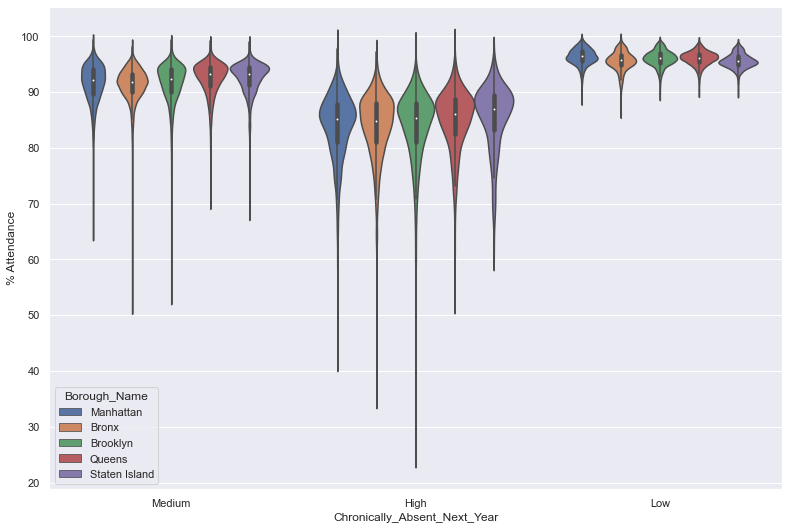

In [135]:
sns.violinplot(x='Chronically_Absent_Next_Year', y='% Attendance', hue='Borough_Name', data=attendance_18_19)

<AxesSubplot:xlabel='Borough_Name', ylabel='% Attendance - diff from 2 yr avg'>

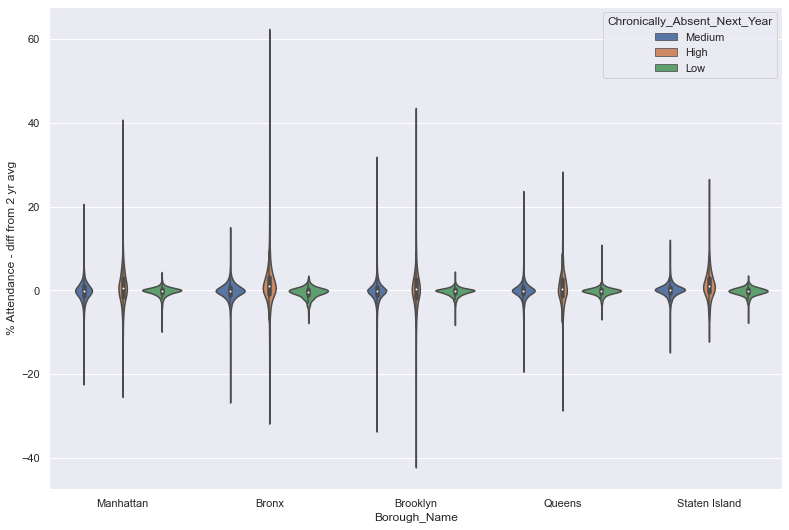

In [129]:
sns.violinplot(x='Borough_Name', y='% Attendance - diff from 2 yr avg', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

<AxesSubplot:xlabel='Borough_Name', ylabel='% Attendance - diff from 5 yr avg'>

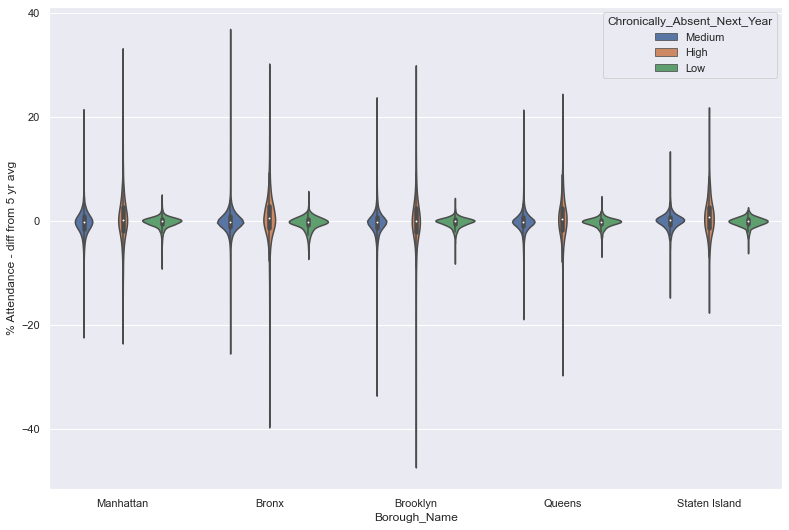

In [130]:
sns.violinplot(x='Borough_Name', y='% Attendance - diff from 5 yr avg', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

In [ ]:
sns.violinplot(x='Borough_Name', y='% Attendance - diff from 2 yr avg', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

<AxesSubplot:xlabel='Chronically_Absent_Next_Year', ylabel='% Attendance - diff from 5 yr avg'>

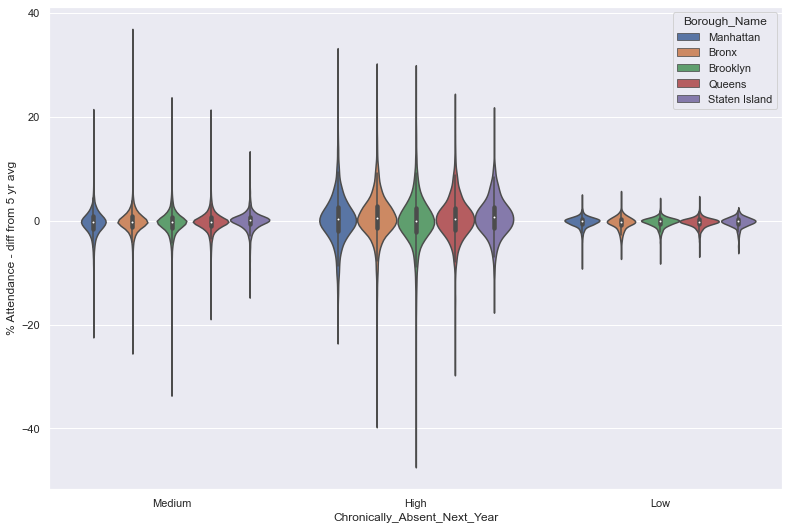

In [125]:
sns.violinplot(x='Chronically_Absent_Next_Year', y='% Attendance - diff from 5 yr avg', hue='Borough_Name', data=attendance_18_19)

In [ ]:
#g = sns.catplot(x="sex", y="total_bill",
                hue="smoker", col="time",
                data=tips, kind="violin",
                height=4, aspect=.7);

<AxesSubplot:xlabel='% Attendance', ylabel='% Chronically Absent'>

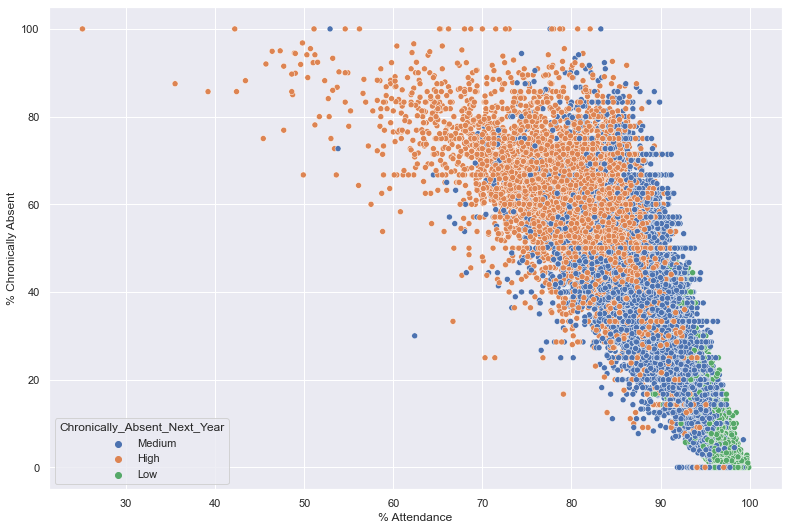

In [121]:
sns.scatterplot(x='% Attendance', y='% Chronically Absent', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

<AxesSubplot:xlabel='% Attendance - diff from 5 yr avg', ylabel='% Chronically Absent - diff from 5 yr avg'>

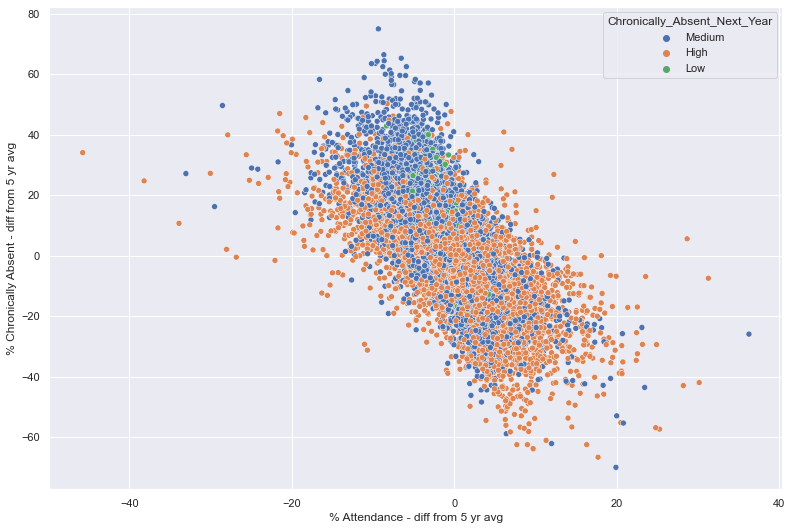

In [131]:
sns.scatterplot(x='% Attendance - diff from 5 yr avg', y='% Chronically Absent - diff from 5 yr avg', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

<AxesSubplot:xlabel='% Attendance - diff from 2 yr avg', ylabel='% Chronically Absent - diff from 2 yr avg'>

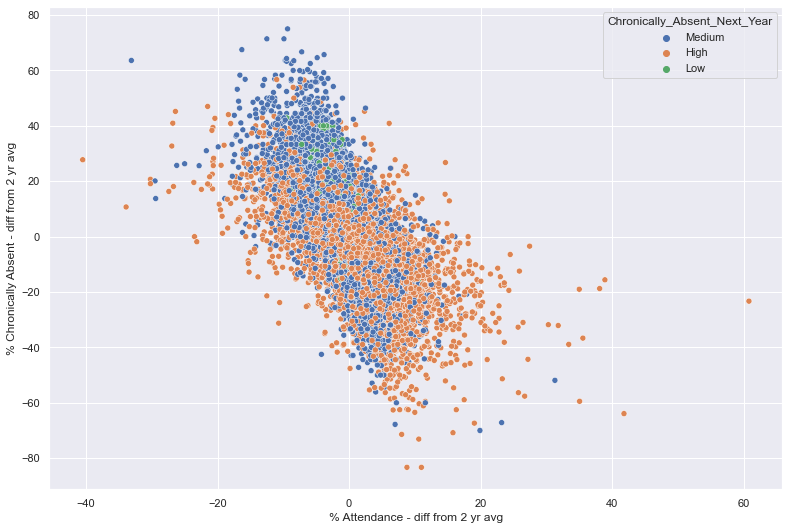

In [132]:
sns.scatterplot(x='% Attendance - diff from 2 yr avg', y='% Chronically Absent - diff from 2 yr avg', hue='Chronically_Absent_Next_Year', data=attendance_18_19)

In [115]:
attendance_18_19.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Demographic Variable',
       '% Attendance', '% Chronically Absent', 'District_Number',
       'Borough_Name', '% Attendance - diff from 5 yr avg',
       '% Attendance - diff from 2 yr avg',
       '% Chronically Absent - diff from 5 yr avg',
       '% Chronically Absent - diff from 2 yr avg',
       'Chronically_Absent_Next_Year'],
      dtype='object')

In [124]:
attendance_18_19.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Demographic Variable',
       '% Attendance', '% Chronically Absent', 'District_Number',
       'Borough_Name', '% Attendance - diff from 5 yr avg',
       '% Attendance - diff from 2 yr avg',
       '% Chronically Absent - diff from 5 yr avg',
       '% Chronically Absent - diff from 2 yr avg',
       'Chronically_Absent_Next_Year'],
      dtype='object')

In [122]:
def see_target_interactions(dataframe, target_variable):
    '''vizualize scatterplot to see interaction between target variable and each variable'''
    for col in dataframe.columns:
        sns.scatterplot(x=col, y=target_variable, data=dataframe)
        plt.show()

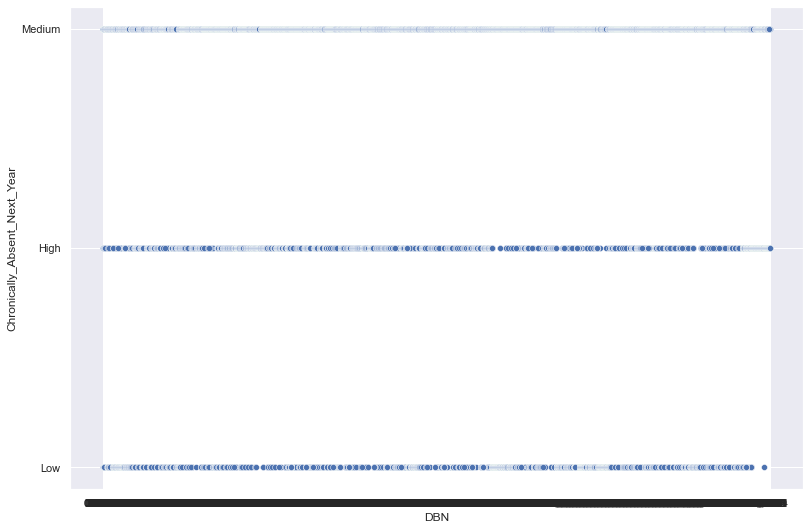

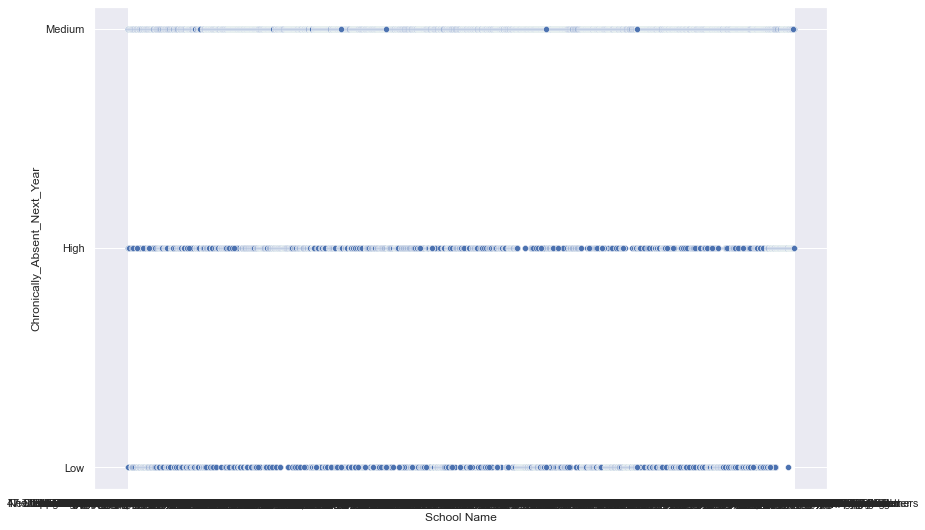

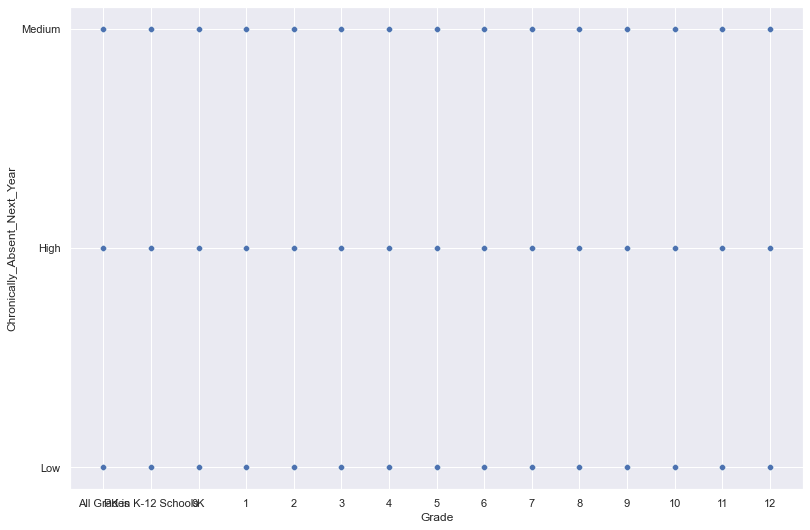

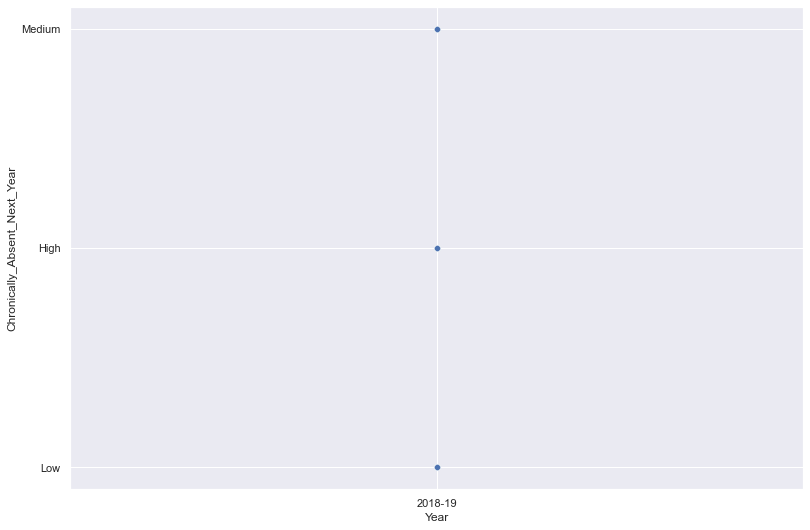

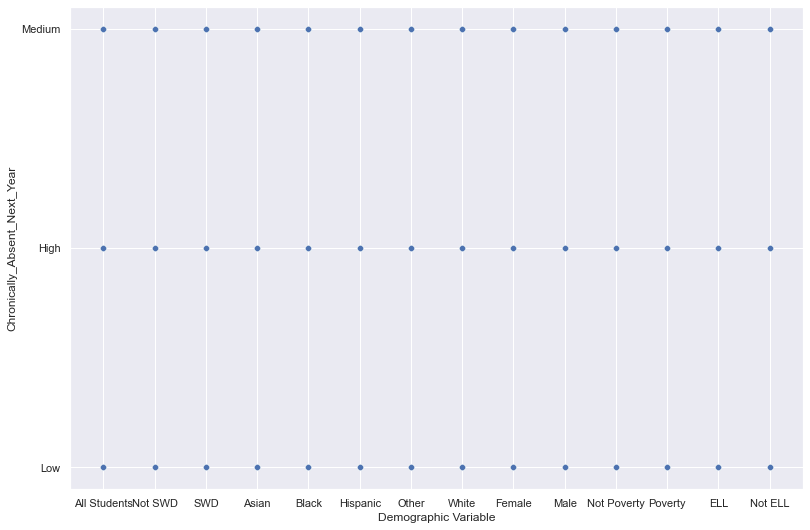

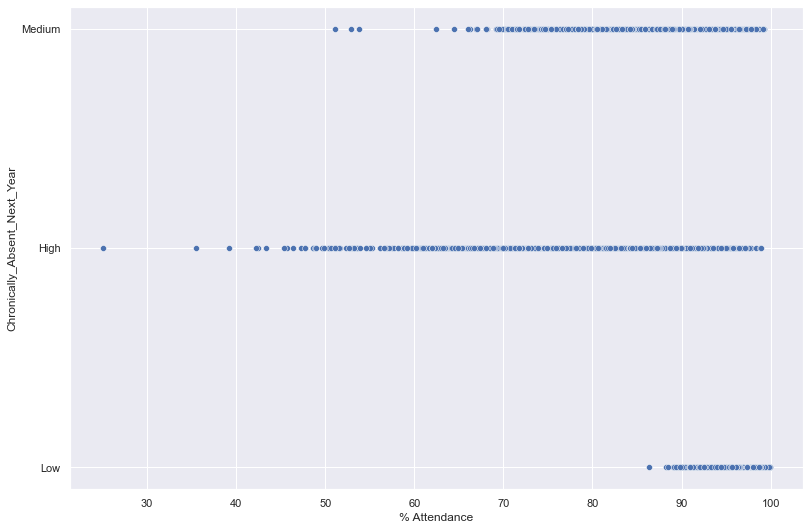

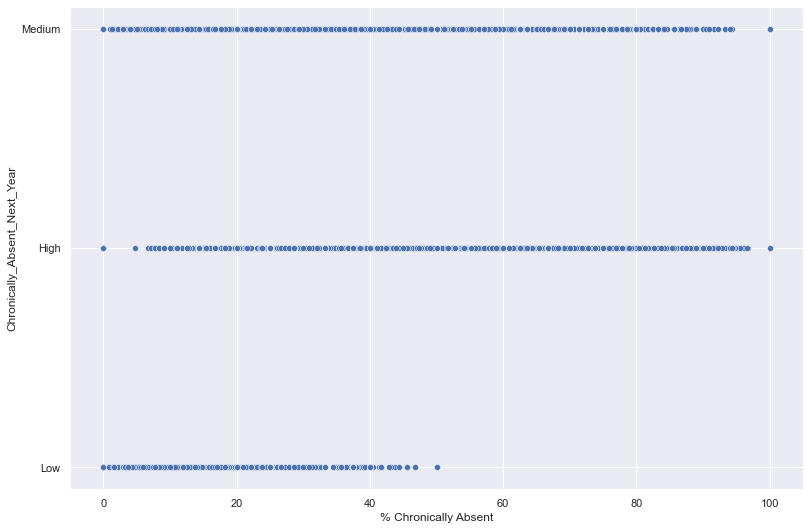

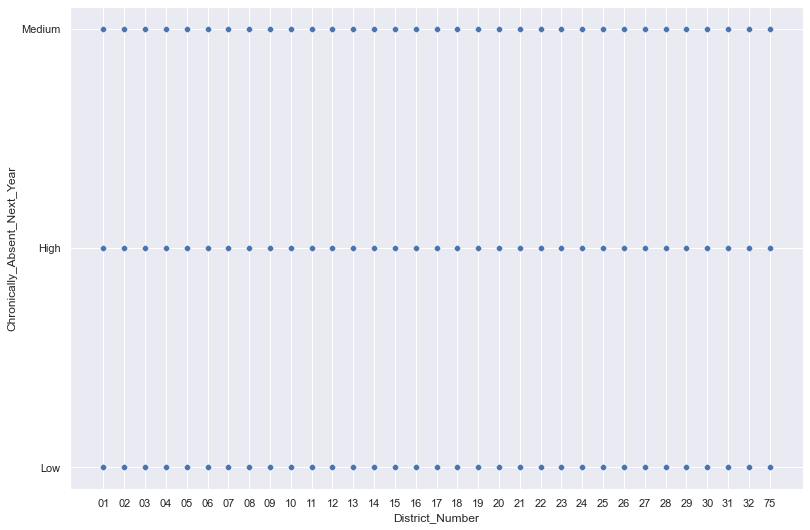

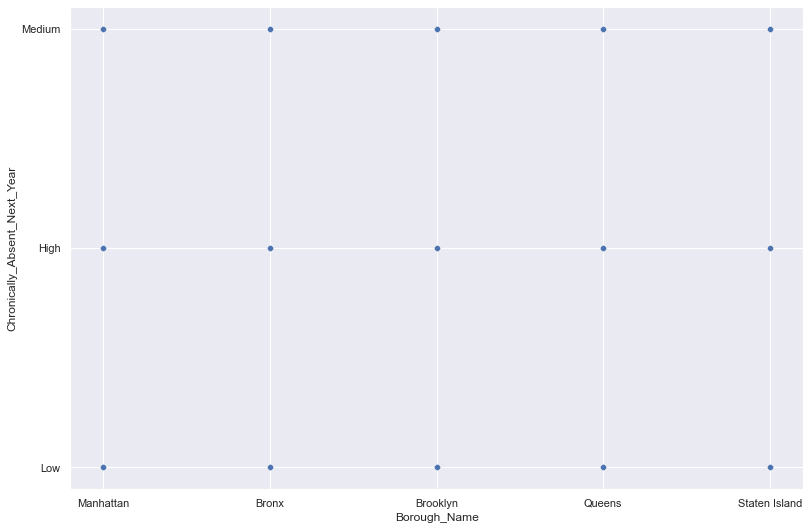

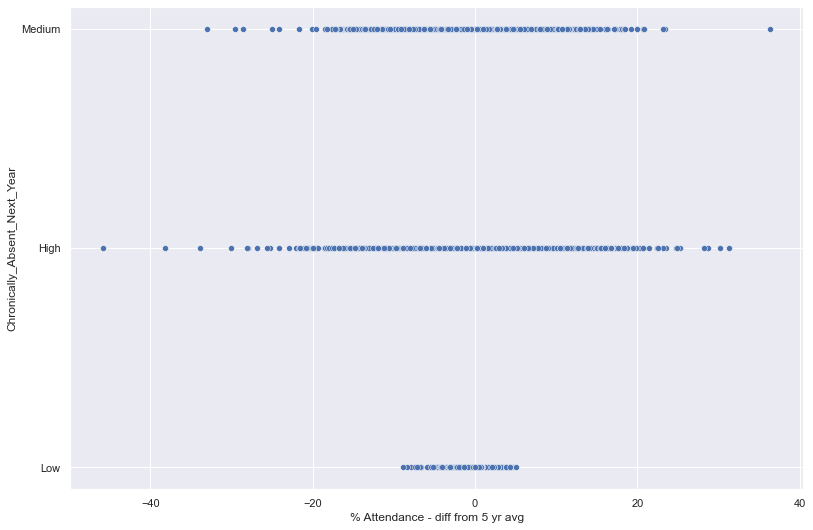

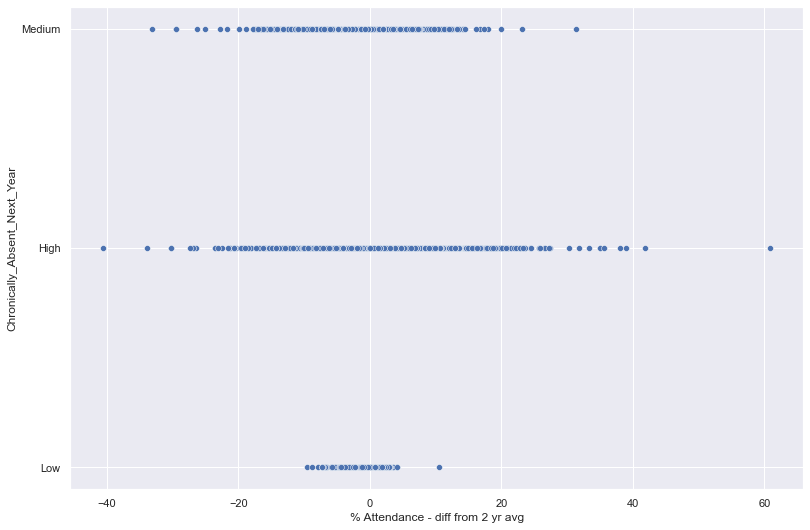

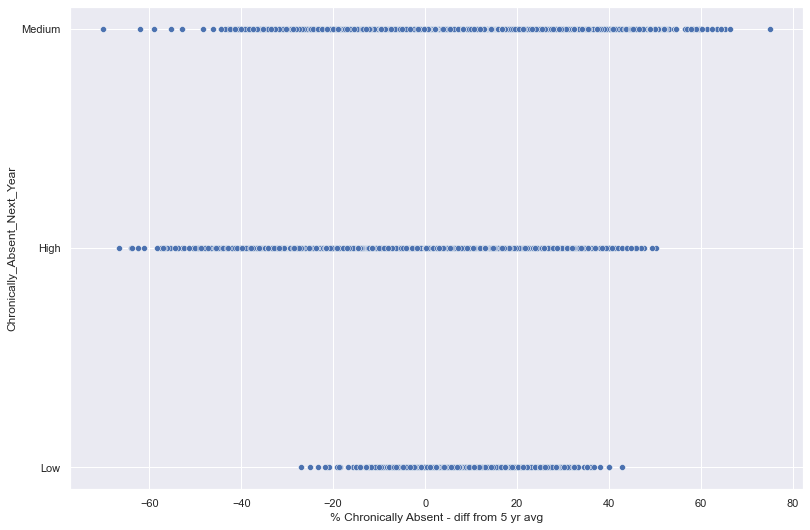

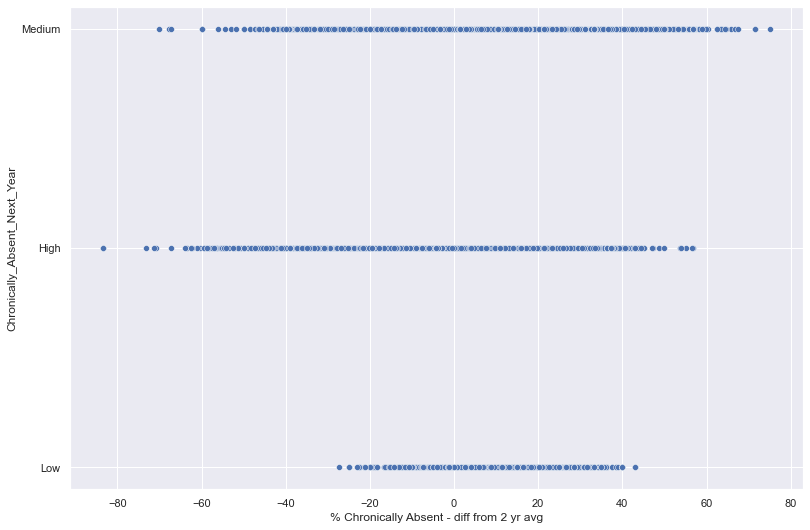

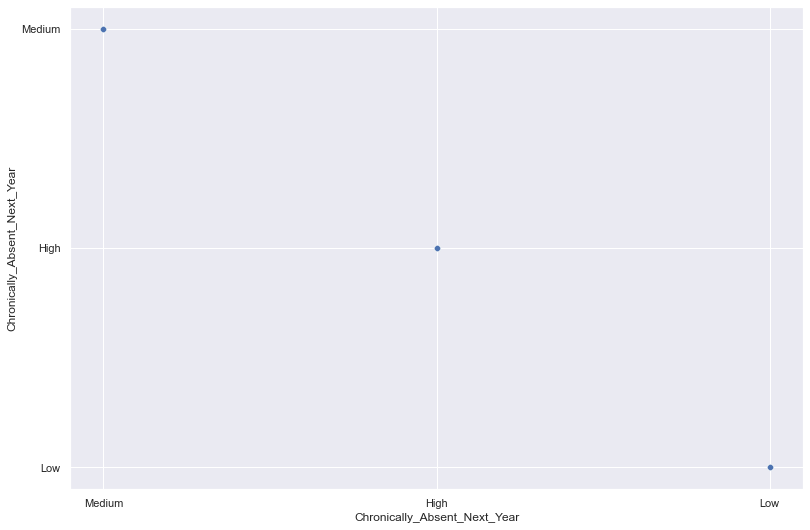

In [123]:
see_target_interactions(attendance_18_19, 'Chronically_Absent_Next_Year')

In [187]:
attendance_18_19.describe()

,% Attendance,% Chronically Absent,% Attendance - diff from 5 yr avg,% Attendance - diff from 2 yr avg,% Chronically Absent - diff from 5 yr avg,% Chronically Absent - diff from 2 yr avg
count,97859.000000,97859.000000,97859.000000,97859.000000,97859.000000,97859.000000
mean,91.295671,28.544893,-0.197762,-0.075030,1.578850,0.810310
std,4.994116,17.857739,2.584149,2.610692,10.004628,10.389123
min,25.100000,0.000000,-45.760000,-40.500000,-70.000000,-83.300000
25%,89.300000,14.300000,-1.160000,-1.000000,-3.480000,-4.250000
50%,92.400000,26.300000,-0.160000,-0.050000,1.266667,0.600000
75%,94.700000,40.400000,0.760000,0.850000,6.640000,5.800000
max,99.900000,100.000000,36.280000,60.800000,75.000000,75.000000


## Look by boroughs for lowest chronic absenteeism for:
- grades 9-12
- PreK & K
- SWD
- Black, Hispanic

This shows boroughs that are doing well in the variables with the highest rates of chronic absenteeism. They could be studied for best practices to share with others.

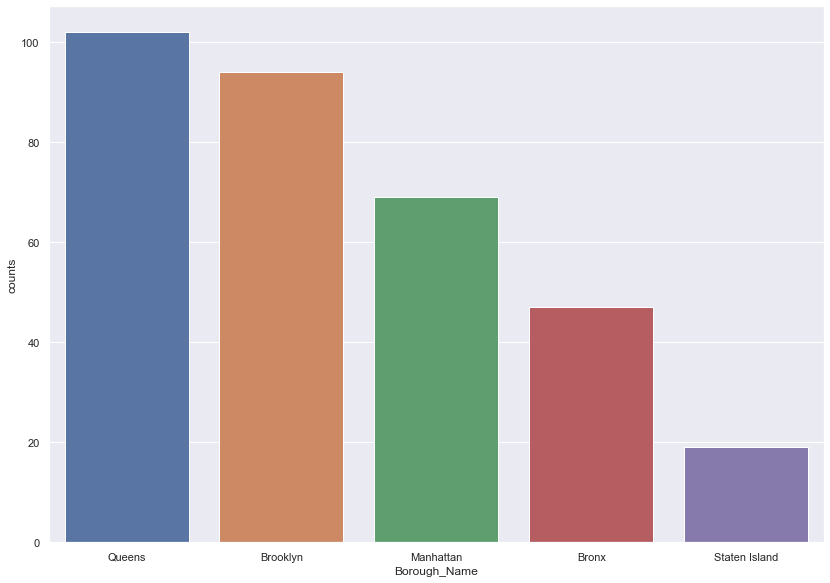

In [188]:
#plot top boroughs for lowest next year chronic absenteesim in 'Black' students
#(higher number = more instances)
ax = sns.barplot(x='Borough_Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'Black'].groupby(by='Borough_Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

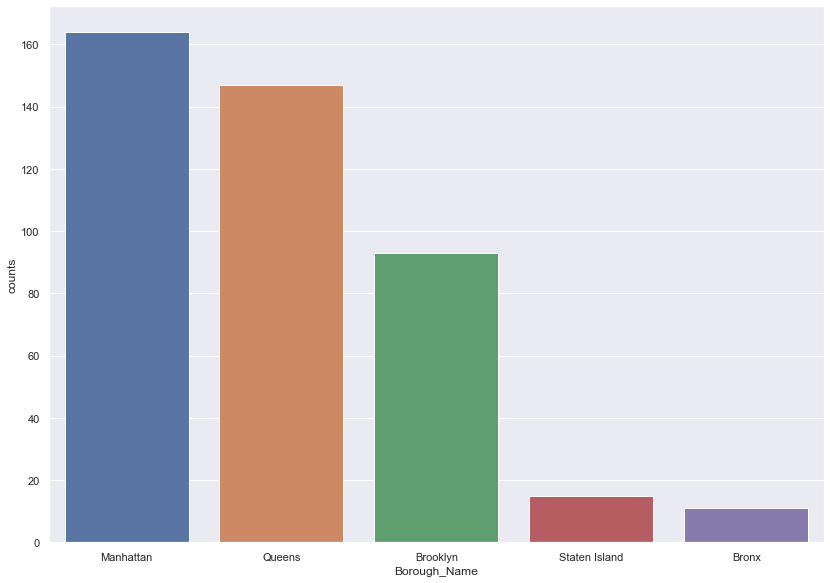

In [189]:
#plot top boroughs for lowest next year chronic absenteesim in 'SWD' (students with disabilities)
#(higher number = more instances)
ax = sns.barplot(x='Borough_Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'SWD'].groupby(by='Borough_Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

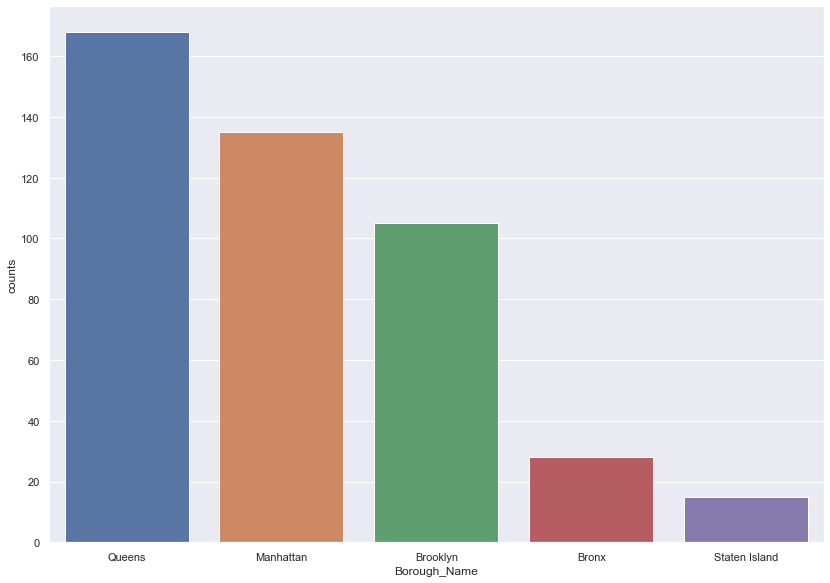

In [190]:
#plot top boroughs for lowest next year chronic absenteesim in 'Hispanic' students
#(higher number = more instances)
ax = sns.barplot(x='Borough_Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'Hispanic'].groupby(by='Borough_Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

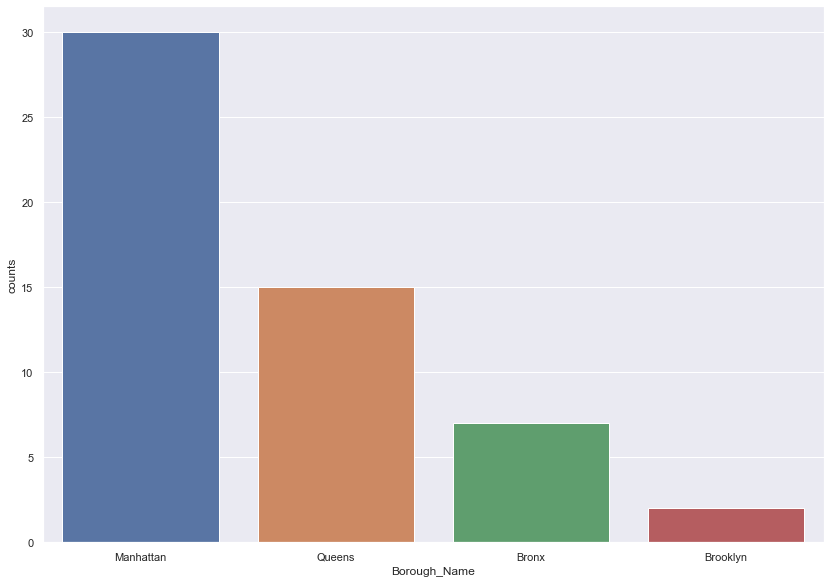

In [191]:
#plot top boroughs for lowest next year chronic absenteesim in Grade 12 students
#(higher number = more instances)
ax = sns.barplot(x='Borough_Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == '12'].groupby(by='Borough_Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

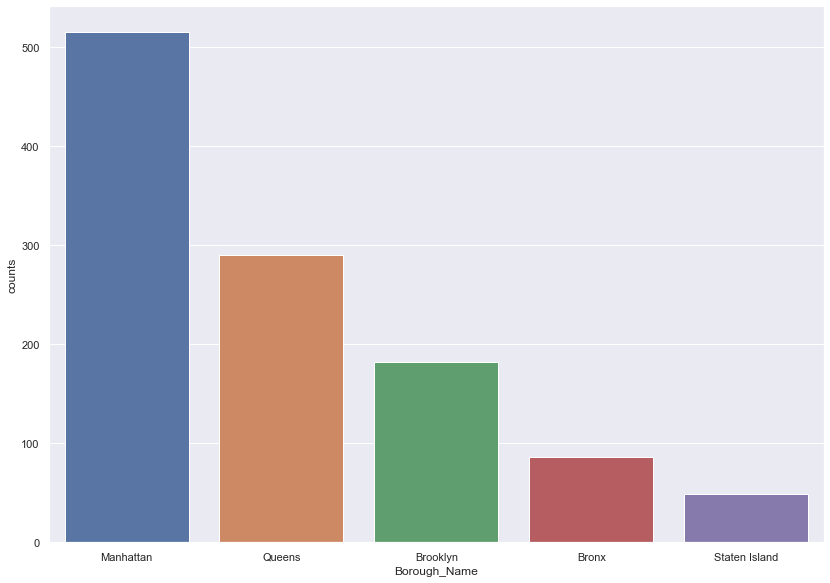

In [192]:
#plot top boroughs for lowest next year chronic absenteesim in Grades 9-12 students
#(higher number = more instances)
grades = ['9', '10', '11', '12']

ax = sns.barplot(x='Borough_Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'].isin(grades)].groupby(by='Borough_Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

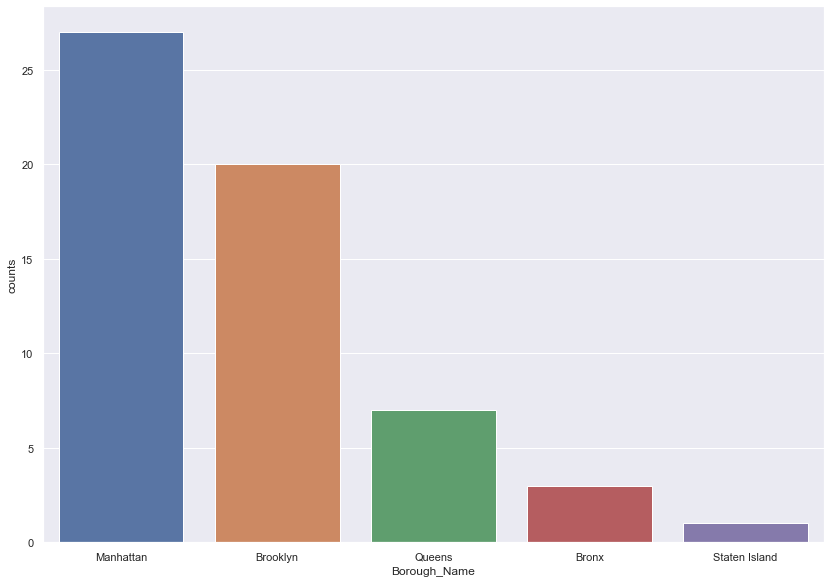

In [193]:
#plot top boroughs for lowest next year chronic absenteesim in PK in K-12 Schools students
#(higher number = more instances)
ax = sns.barplot(x='Borough_Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == 'PK in K-12 Schools'].groupby(by='Borough_Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

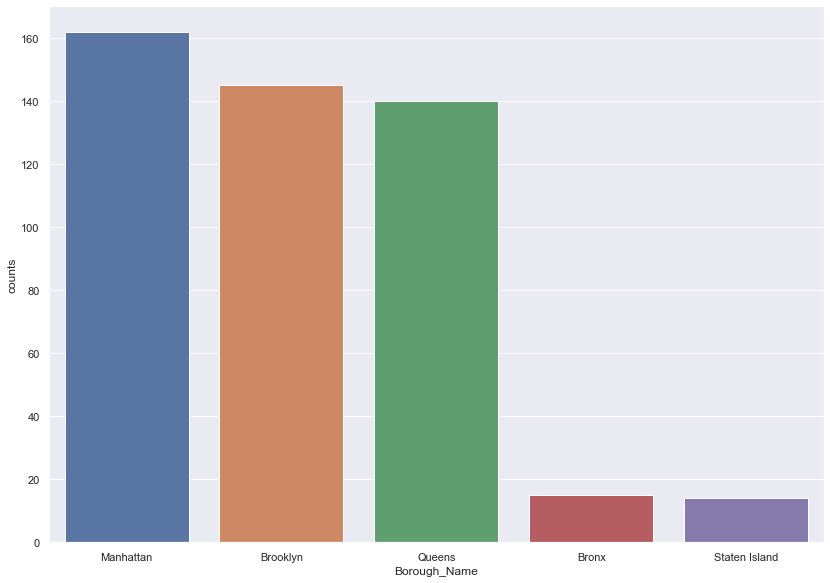

In [194]:
#plot top boroughs for lowest next year chronic absenteesim in 0K in K-12 Schools students
#(higher number = more instances)
ax = sns.barplot(x='Borough_Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == '0K'].groupby(by='Borough_Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

## Look for schools that have low chronic absenteeism for:
- grades 9-12
- PreK & K
- SWD
- Black, Hispanic

These are schools that are doing well in the variables with the highest rates of chronic absenteeism. They could be studied for best practices to share with others.

In [143]:
attendance_18_19['Demographic Variable'].unique()

array(['All Students', 'Not SWD', 'SWD', 'Asian', 'Black', 'Hispanic',
       'Other', 'White', 'Female', 'Male', 'Not Poverty', 'Poverty',
       'ELL', 'Not ELL'], dtype=object)

In [161]:
#filter data for Low Chronically Absent Next Year
low_chronic_absent = attendance_18_19[attendance_18_19['Chronically_Absent_Next_Year'] == 'Low']

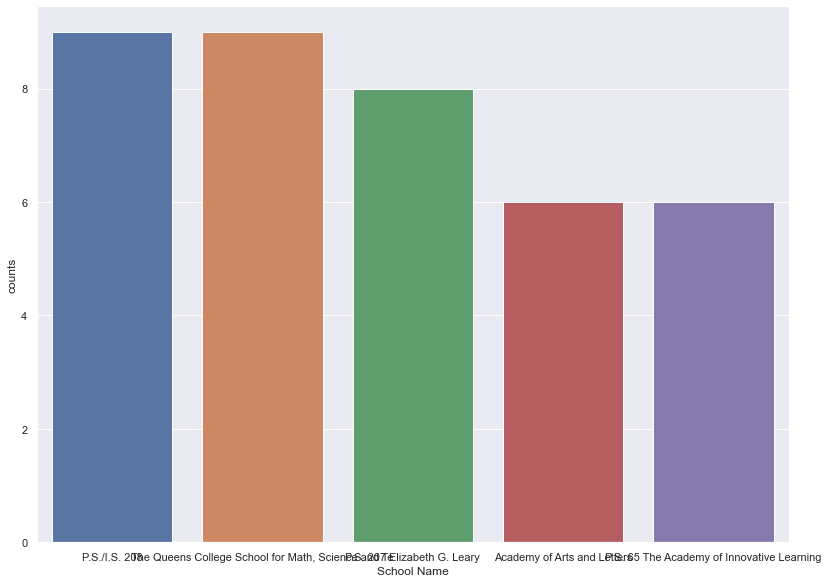

In [165]:
#plot top schools for lowest next year chronic absenteesim in 'Black' students
#(higher number = more instances)
ax = sns.barplot(x='School Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'Black'].groupby(by='School Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

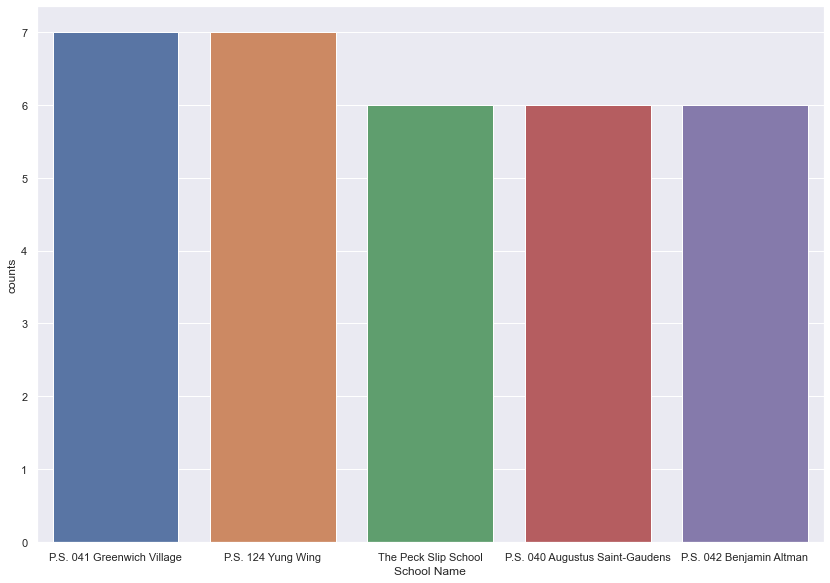

In [198]:
#plot top schools for lowest next year chronic absenteesim in 'SWD' (students with disabilities)
#(higher number = more instances)
ax = sns.barplot(x='School Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'SWD'].groupby(by='School Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

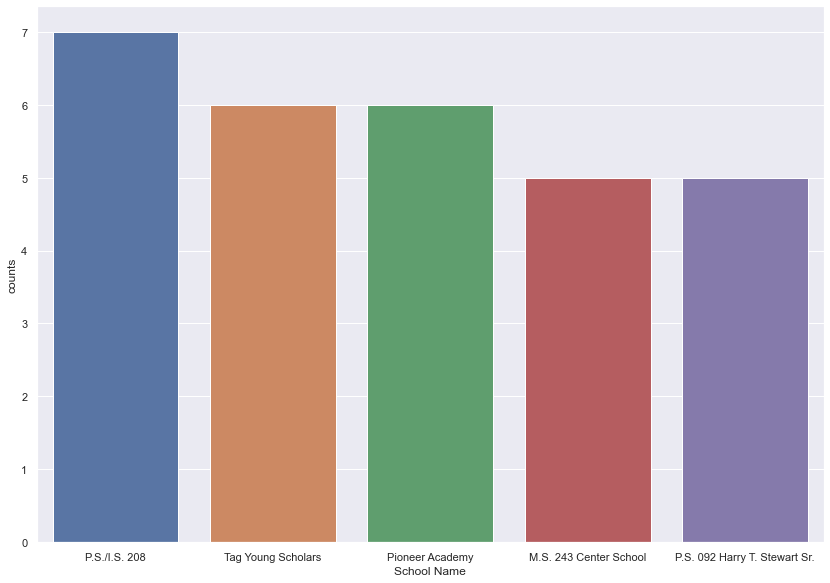

In [169]:
#plot top schools for lowest next year chronic absenteesim in 'Hispanic' students
#(higher number = more instances)
ax = sns.barplot(x='School Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'Hispanic'].groupby(by='School Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

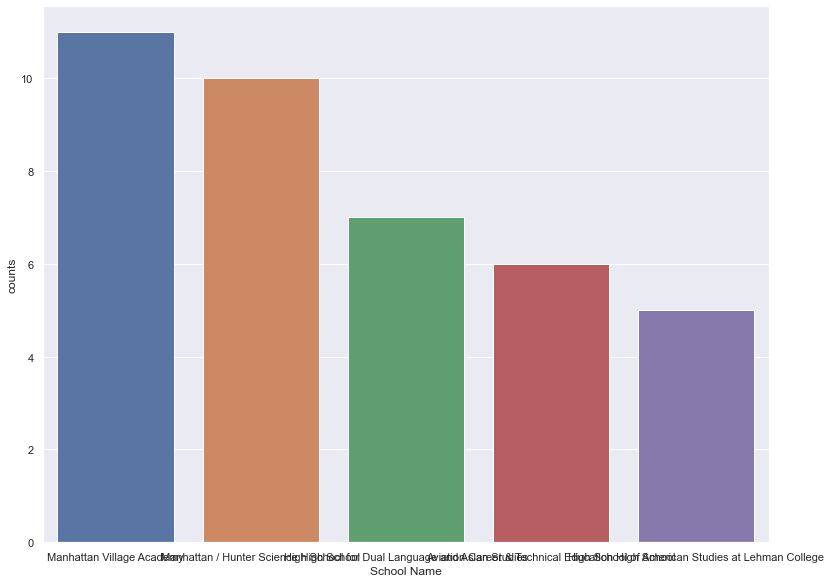

In [172]:
#plot top schools for lowest next year chronic absenteesim in Grade 12 students
#(higher number = more instances)
ax = sns.barplot(x='School Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == '12'].groupby(by='School Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

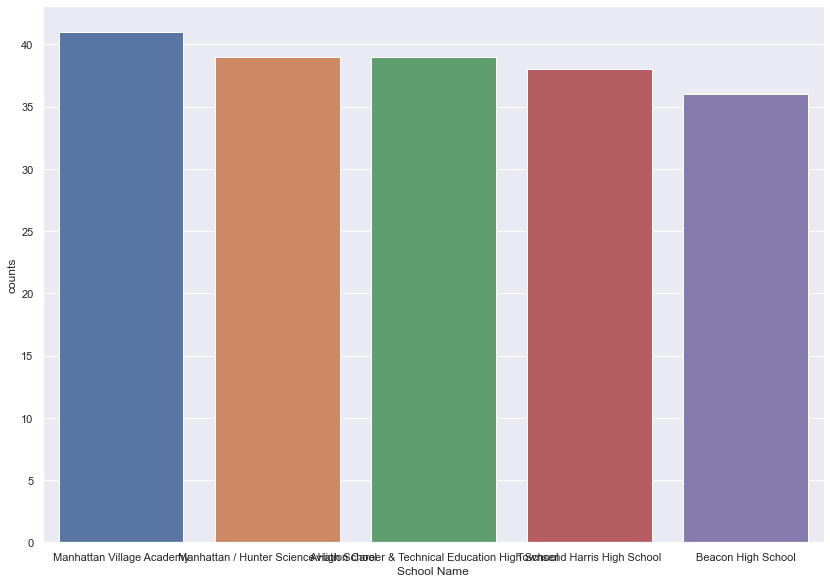

In [174]:
#plot top schools for lowest next year chronic absenteesim in Grades 9-12 students
#(higher number = more instances)
grades = ['9', '10', '11', '12']

ax = sns.barplot(x='School Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'].isin(grades)].groupby(by='School Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

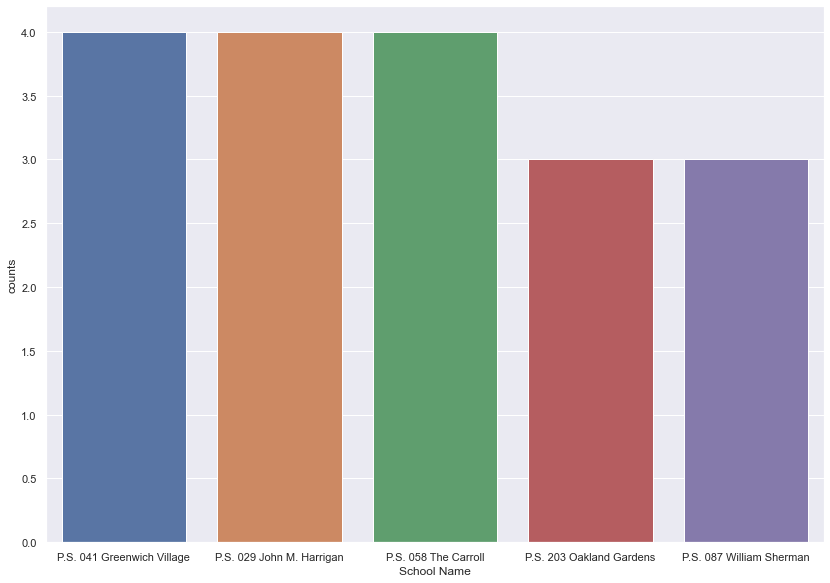

In [175]:
#plot top schools for lowest next year chronic absenteesim in PK in K-12 Schools students
#(higher number = more instances)
ax = sns.barplot(x='School Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == 'PK in K-12 Schools'].groupby(by='School Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

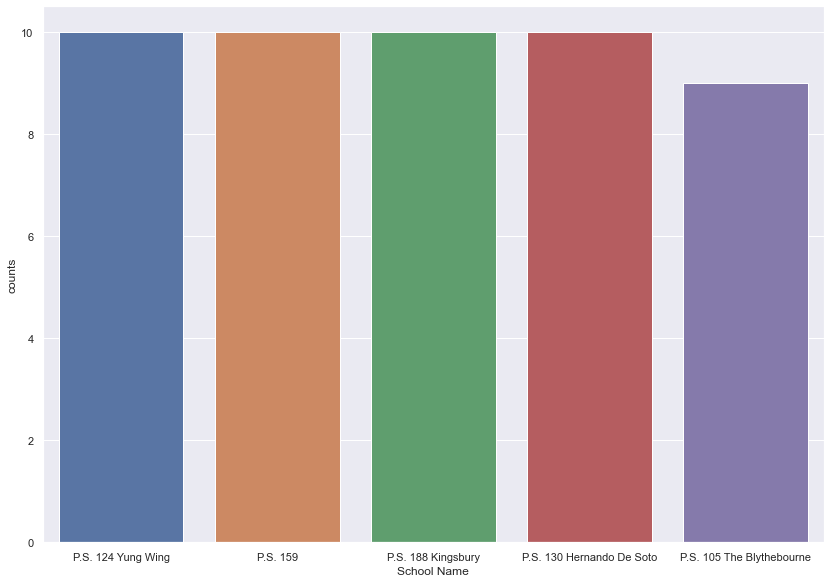

In [176]:
#plot top schools for lowest next year chronic absenteesim in PK in K-12 Schools students
#(higher number = more instances)
ax = sns.barplot(x='School Name', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == '0K'].groupby(by='School Name').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

## Look for districts that have low chronic absenteeism for:
- grades 9-12
- PreK & K
- SWD
- Black, Hispanic

These are districs that are doing well in the variables with the highest rates of chronic absenteeism. They could be studied for best practices to share with others.

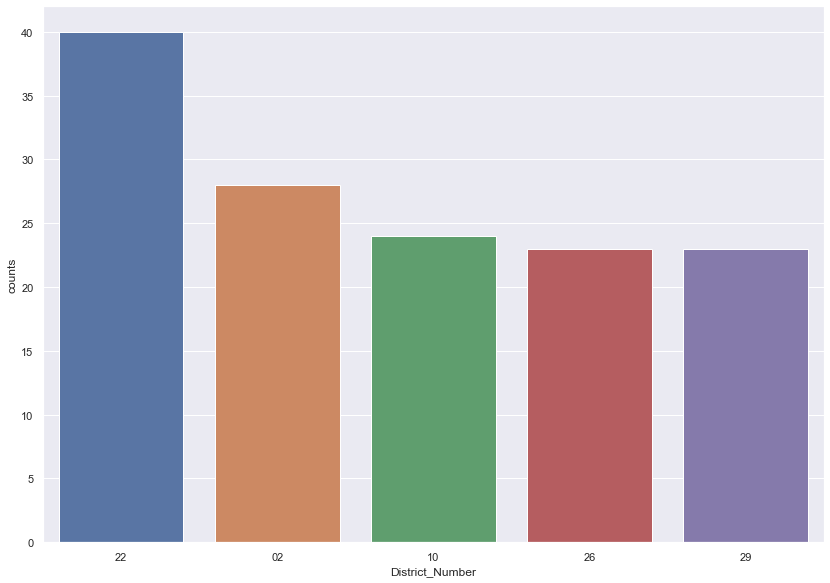

In [180]:
#plot top districts for lowest next year chronic absenteesim in 'Black' students
#(higher number = more instances)
ax = sns.barplot(x='District_Number', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'Black'].groupby(by='District_Number').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

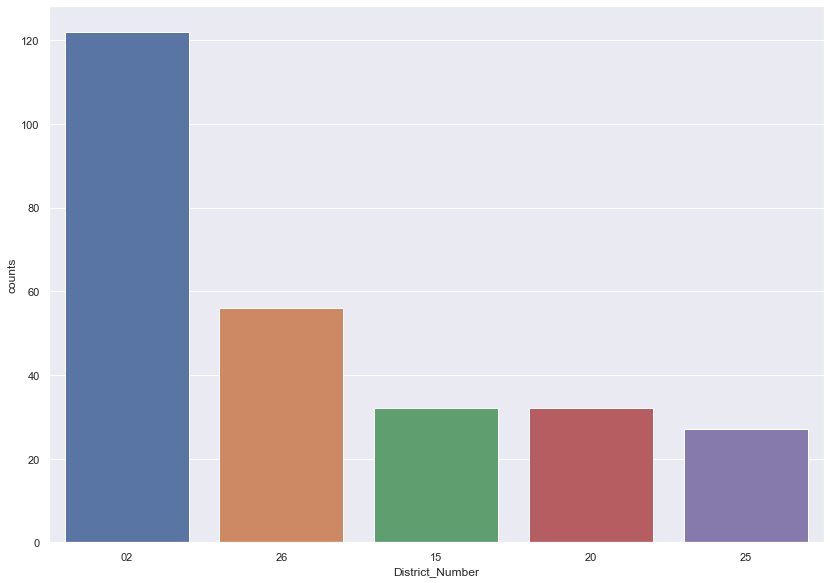

In [181]:
#plot top districts for lowest next year chronic absenteesim in 'SWD' (students with disabilities)
#(higher number = more instances)
ax = sns.barplot(x='District_Number', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'SWD'].groupby(by='District_Number').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

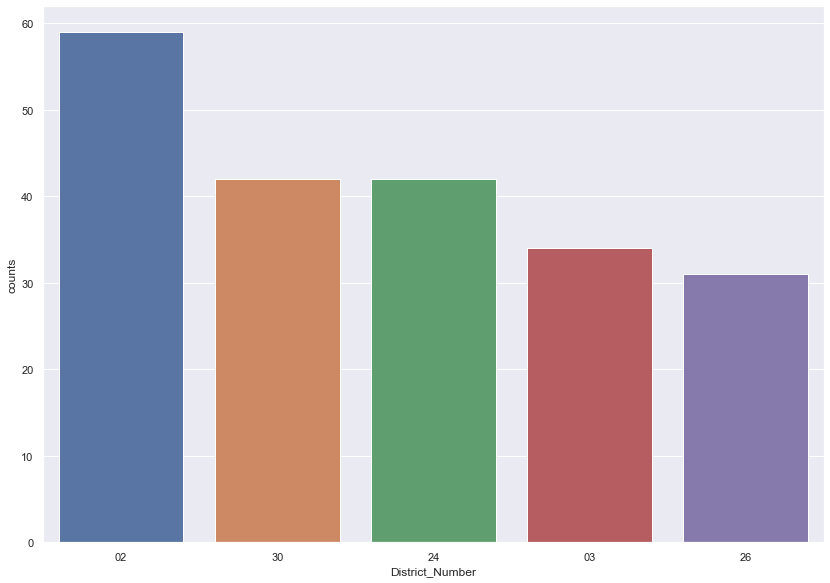

In [182]:
#plot top schools for lowest next year chronic absenteesim in 'Hispanic' students
#(higher number = more instances)
ax = sns.barplot(x='District_Number', y='DBN', data=low_chronic_absent[low_chronic_absent['Demographic Variable'] == 'Hispanic'].groupby(by='District_Number').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

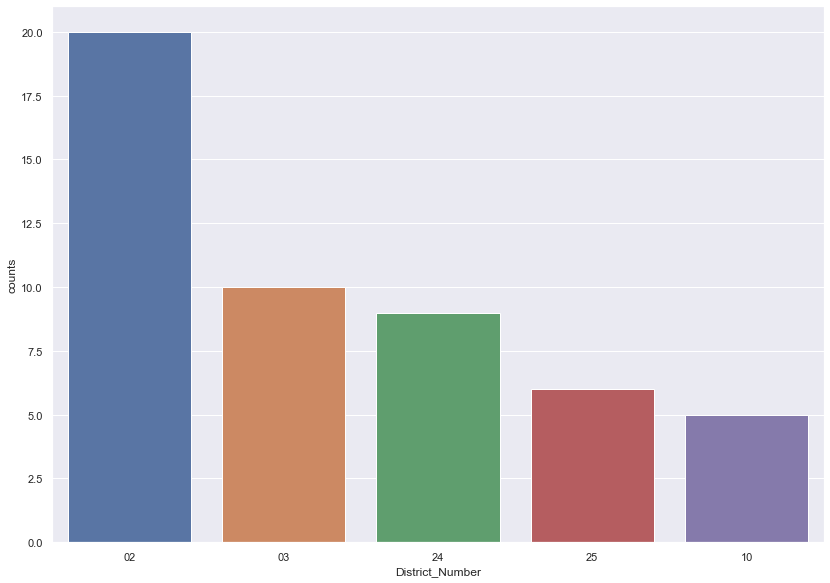

In [183]:
#plot top districts for lowest next year chronic absenteesim in Grade 12 students
#(higher number = more instances)
ax = sns.barplot(x='District_Number', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == '12'].groupby(by='District_Number').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

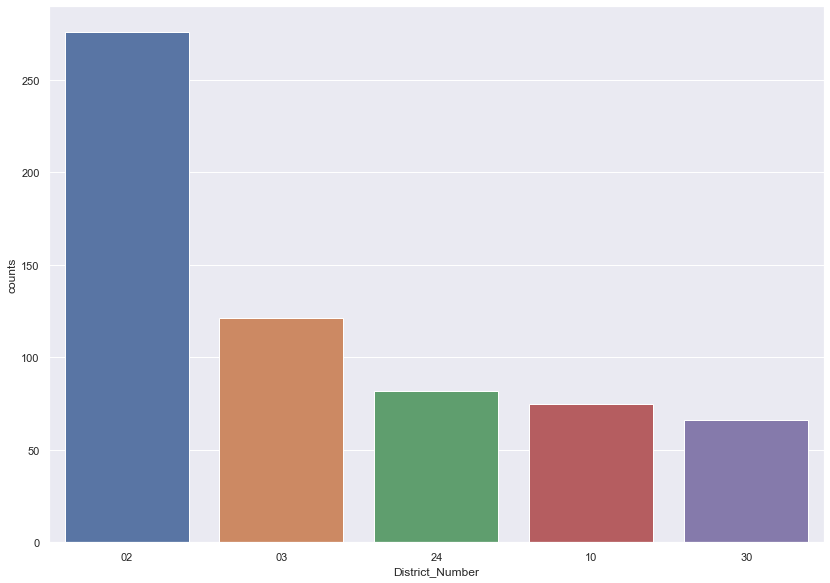

In [184]:
#plot top districts for lowest next year chronic absenteesim in Grades 9-12 students
#(higher number = more instances)
grades = ['9', '10', '11', '12']

ax = sns.barplot(x='District_Number', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'].isin(grades)].groupby(by='District_Number').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

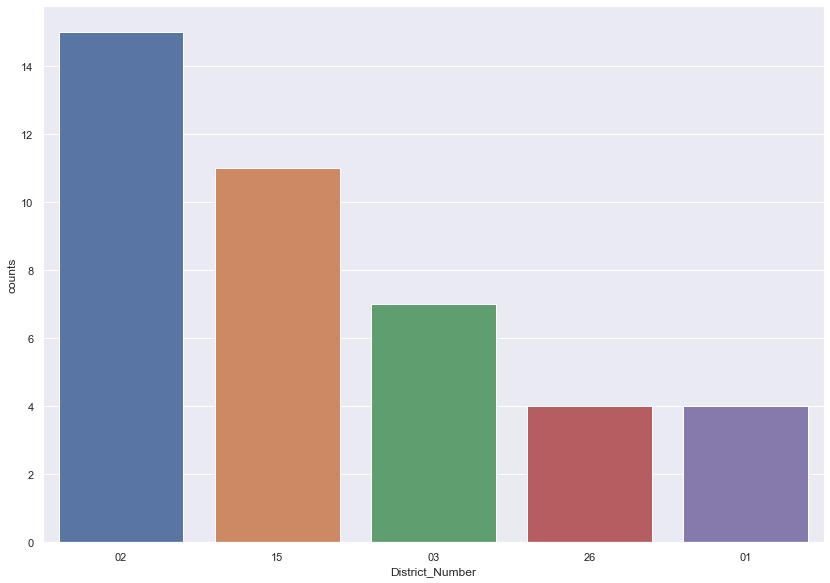

In [185]:
#plot top districts for lowest next year chronic absenteesim in PK in K-12 Schools students
#(higher number = more instances)
ax = sns.barplot(x='District_Number', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == 'PK in K-12 Schools'].groupby(by='District_Number').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

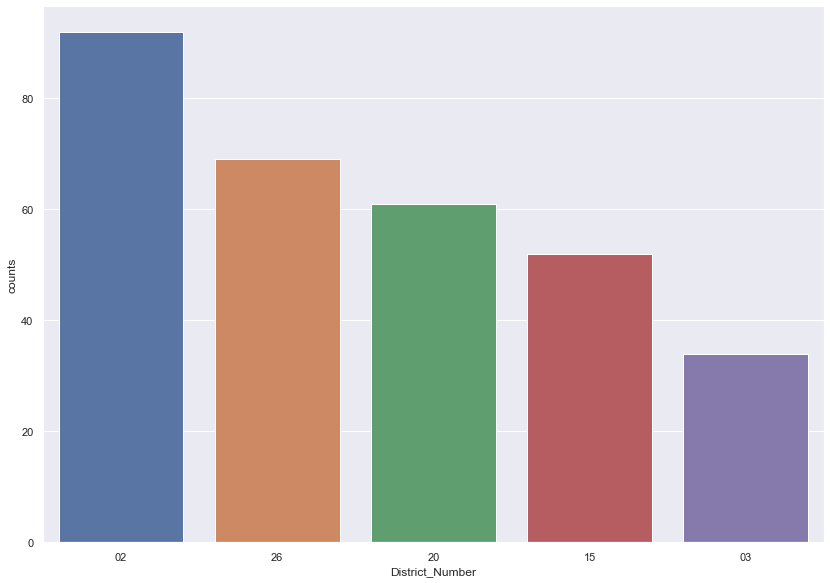

In [186]:
#plot top schools for lowest next year chronic absenteesim in 0K in K-12 Schools students
#(higher number = more instances)
ax = sns.barplot(x='District_Number', y='DBN', data=low_chronic_absent[low_chronic_absent['Grade'] == '0K'].groupby(by='District_Number').count().sort_values(by='DBN', ascending=False).reset_index().head(5))
ax.set(ylabel='counts')
plt.tight_layout()
plt.show()

In [179]:
attendance_18_19.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Demographic Variable',
       '% Attendance', '% Chronically Absent', 'District_Number',
       'Borough_Name', '% Attendance - diff from 5 yr avg',
       '% Attendance - diff from 2 yr avg',
       '% Chronically Absent - diff from 5 yr avg',
       '% Chronically Absent - diff from 2 yr avg',
       'Chronically_Absent_Next_Year'],
      dtype='object')

In [ ]:
«